In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet, LogisticRegression
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestClassifier, GradientBoostingClassifier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import MeanSquaredError

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading and Pre-Processing the available Datasets

In [ ]:
h = pd.read_csv(r'/content/drive/MyDrive/WiDS/DataSets/matches.csv')
ballData = pd.read_csv(r'/content/drive/MyDrive/WiDS/DataSets/deliveries.csv')
h.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [ ]:
ballData.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [ ]:
h['city'] = h['city'].fillna('Dubai')
h = h.replace({'Rising Pune Supergiants': 'Rising Pune Supergiant'}, regex=True)
h = h[h.winner.notna()]

ballData.drop(ballData[ballData.inning.isin([3,4,5])].index, inplace=True)

In [ ]:
l = []

for match in list(ballData['match_id'].unique()) :
    temp1 = ballData[ballData['match_id']==match][ballData['inning']==1]
    temp2 = ballData[ballData['match_id']==match][ballData['inning']==2]
    temp1['cumulative'] = temp1['total_runs'].cumsum()
    temp2['cumulative'] = temp2['total_runs'].cumsum()
    
    l.extend(list(temp1['cumulative']))
    l.extend(list(temp2['cumulative']))
    
ballData['cumulative']=l

In [ ]:
ballData['player_dismissed'] = ballData['player_dismissed'].fillna('0')
ballData.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,cumulative
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,0,NaN,NaN,4
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,4
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,0,NaN,NaN,6


In [ ]:
new = []
for row in range(178982) :
    if ballData.iloc[row]['player_dismissed']!='0' :
        new.append(1)
    else :
        new.append(0)
        
ballData['is_wicket'] = new

In [ ]:
l2 = []

for match in list(ballData['match_id'].unique()) :
    temp1 = ballData[ballData['match_id']==match][ballData['inning']==1]
    temp2 = ballData[ballData['match_id']==match][ballData['inning']==2]
    temp1['cumulative'] = temp1['is_wicket'].cumsum()
    temp2['cumulative'] = temp2['is_wicket'].cumsum()
    
    l2.extend(list(temp1['cumulative']))
    l2.extend(list(temp2['cumulative']))
ballData['cumulative_wickets']=l2

In [ ]:
ballData.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,cumulative,is_wicket,cumulative_wickets
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,0,NaN,NaN,4,0,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,4,0,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,0,NaN,NaN,6,0,0


In [ ]:
ballData['cumulative_wickets'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
h.rename(columns={'id':'match_id'}, inplace=True)
ballData['over_ball'] = ballData['over'].astype(str) + '.' + ballData['ball'].astype(str)

In [ ]:
l1 = list(ballData[ballData.inning==1]['match_id'].unique())
l2 = list(ballData[ballData.inning==2]['match_id'].unique())

removal = [x for x in l1 if x not in l2]  # Removing this data since match was abandoned

ballData.drop(ballData[ballData.match_id.isin(removal)].index, inplace=True)

ballData.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,cumulative,is_wicket,cumulative_wickets,over_ball
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,1.1
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,1.2
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,0,NaN,NaN,4,0,0,1.3
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,4,0,0,1.4
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,0,NaN,NaN,6,0,0,1.5


In [ ]:
addition = []
for i in list(ballData['match_id'].unique()) :
    i1 = ballData[ballData.match_id==i][ballData.inning==1]['cumulative'].iloc[-1]
    num1 = len(ballData[ballData.match_id==i][ballData.inning==1])
    i2 = ballData[ballData.match_id==i][ballData.inning==2]['cumulative'].iloc[-1]
    num2 = len(ballData[ballData.match_id==i][ballData.inning==2])
    addition.extend([i1]*num1)
    addition.extend([i2]*num2)

ballData['score'] = addition
ballData.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,cumulative,is_wicket,cumulative_wickets,over_ball,score
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,1.1,207
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,1.2,207
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,0,NaN,NaN,4,0,0,1.3,207
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN,4,0,0,1.4,207
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,0,NaN,NaN,6,0,0,1.5,207


In [ ]:
data = pd.merge(h[['match_id','season','city','venue']], ballData, on='match_id')
data.columns

Index(['match_id', 'season', 'city', 'venue', 'inning', 'batting_team',
       'bowling_team', 'over', 'ball', 'batsman', 'non_striker', 'bowler',
       'is_super_over', 'wide_runs', 'bye_runs', 'legbye_runs', 'noball_runs',
       'penalty_runs', 'batsman_runs', 'extra_runs', 'total_runs',
       'player_dismissed', 'dismissal_kind', 'fielder', 'cumulative',
       'is_wicket', 'cumulative_wickets', 'over_ball', 'score'],
      dtype='object')

In [ ]:
dataset = data[['match_id','season','city','inning','batting_team','bowling_team','over_ball','cumulative','cumulative_wickets','score']]
dataset.head()

,match_id,season,city,inning,batting_team,bowling_team,over_ball,cumulative,cumulative_wickets,score
0,1,2017,Hyderabad,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.1,0,0,207
1,1,2017,Hyderabad,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.2,0,0,207
2,1,2017,Hyderabad,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.3,4,0,207
3,1,2017,Hyderabad,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.4,4,0,207
4,1,2017,Hyderabad,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.5,6,0,207


In [ ]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['city'], drop_first=True)], axis=1)
dataset = dataset.drop(['city'], axis=1)
dataset.head()

,match_id,season,inning,batting_team,bowling_team,over_ball,cumulative,cumulative_wickets,score,Ahmedabad,Bangalore,Bengaluru,Bloemfontein,Cape Town,Centurion,Chandigarh,Chennai,Cuttack,Delhi,Dharamsala,Dubai,Durban,East London,Hyderabad,Indore,Jaipur,Johannesburg,Kanpur,Kimberley,Kochi,Kolkata,Mohali,Mumbai,Nagpur,Port Elizabeth,Pune,Raipur,Rajkot,Ranchi,Sharjah,Visakhapatnam
0,1,2017,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.1,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2017,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.2,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2017,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.3,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2017,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.4,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2017,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.5,6,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['batting_team'], drop_first=True, prefix='bat')], axis=1)
dataset = dataset.drop(['batting_team'], axis=1)
dataset.head()

,match_id,season,inning,bowling_team,over_ball,cumulative,cumulative_wickets,score,Ahmedabad,Bangalore,Bengaluru,Bloemfontein,Cape Town,Centurion,Chandigarh,Chennai,Cuttack,Delhi,Dharamsala,Dubai,Durban,East London,Hyderabad,Indore,Jaipur,Johannesburg,Kanpur,Kimberley,Kochi,Kolkata,Mohali,Mumbai,Nagpur,Port Elizabeth,Pune,Raipur,Rajkot,Ranchi,Sharjah,Visakhapatnam,bat_Deccan Chargers,bat_Delhi Capitals,bat_Delhi Daredevils,bat_Gujarat Lions,bat_Kings XI Punjab,bat_Kochi Tuskers Kerala,bat_Kolkata Knight Riders,bat_Mumbai Indians,bat_Pune Warriors,bat_Rajasthan Royals,bat_Rising Pune Supergiant,bat_Rising Pune Supergiants,bat_Royal Challengers Bangalore,bat_Sunrisers Hyderabad
0,1,2017,1,Royal Challengers Bangalore,1.1,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2017,1,Royal Challengers Bangalore,1.2,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,2017,1,Royal Challengers Bangalore,1.3,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,2017,1,Royal Challengers Bangalore,1.4,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,2017,1,Royal Challengers Bangalore,1.5,6,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['bowling_team'], drop_first=True, prefix='bowl')], axis=1)
dataset = dataset.drop(['bowling_team'], axis=1)
dataset.head()

,match_id,season,inning,over_ball,cumulative,cumulative_wickets,score,Ahmedabad,Bangalore,Bengaluru,Bloemfontein,Cape Town,Centurion,Chandigarh,Chennai,Cuttack,Delhi,Dharamsala,Dubai,Durban,East London,Hyderabad,Indore,Jaipur,Johannesburg,Kanpur,Kimberley,Kochi,Kolkata,Mohali,Mumbai,Nagpur,Port Elizabeth,Pune,Raipur,Rajkot,Ranchi,Sharjah,Visakhapatnam,bat_Deccan Chargers,bat_Delhi Capitals,bat_Delhi Daredevils,bat_Gujarat Lions,bat_Kings XI Punjab,bat_Kochi Tuskers Kerala,bat_Kolkata Knight Riders,bat_Mumbai Indians,bat_Pune Warriors,bat_Rajasthan Royals,bat_Rising Pune Supergiant,bat_Rising Pune Supergiants,bat_Royal Challengers Bangalore,bat_Sunrisers Hyderabad,bowl_Deccan Chargers,bowl_Delhi Capitals,bowl_Delhi Daredevils,bowl_Gujarat Lions,bowl_Kings XI Punjab,bowl_Kochi Tuskers Kerala,bowl_Kolkata Knight Riders,bowl_Mumbai Indians,bowl_Pune Warriors,bowl_Rajasthan Royals,bowl_Rising Pune Supergiant,bowl_Rising Pune Supergiants,bowl_Royal Challengers Bangalore,bowl_Sunrisers Hyderabad
0,1,2017,1,1.1,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,2017,1,1.2,0,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,2017,1,1.3,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,2017,1,1.4,4,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,2017,1,1.5,6,0,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X = pd.concat([dataset.iloc[:, :6], dataset.iloc[:,7:]], axis=1)
y = dataset.iloc[:,6]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

(142888, 66)

**Testing for various HyperParametes : batch_size(for batch gradient descent) and epoch_size, with one hiddent layer containing 5 neurons**

In [ ]:
batch_list = [10,15,20]
epoch_list = [10,20,40]
trial = 0
for epoch_trial in epoch_list :
  for batch_trial in batch_list :
    trial += 1
    print('TRIAL : ', trial, end='\n')
    print('EPOCH :',epoch_trial)
    print('BATCH SIZE :',batch_trial)
    model = Sequential()
    model.add(Dense(units=5, input_dim=66, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train ,batch_size = batch_trial, epochs = epoch_trial, verbose=1)

    rmse = 0
    for y,pred in zip(y_test, model.predict(X_test)) :
        rmse += (y-pred)**2
    remse = rmse**0.5
    print('Root Mean Square Error :', rmse, end='\n')


TRIAL :  1
EPOCH : 10
BATCH SIZE : 10
Epoch 1/10
14289/14289 [==============================] - 19s 1ms/step - loss: 3527.5728
Epoch 2/10
14289/14289 [==============================] - 19s 1ms/step - loss: 797.6792
Epoch 3/10
14289/14289 [==============================] - 19s 1ms/step - loss: 761.5992
Epoch 4/10
14289/14289 [==============================] - 19s 1ms/step - loss: 741.6923
Epoch 5/10
14289/14289 [==============================] - 19s 1ms/step - loss: 724.4855
Epoch 6/10
14289/14289 [==============================] - 19s 1ms/step - loss: 709.3703
Epoch 7/10
14289/14289 [==============================] - 19s 1ms/step - loss: 696.5020
Epoch 8/10
14289/14289 [==============================] - 19s 1ms/step - loss: 685.0309
Epoch 9/10
14289/14289 [==============================] - 19s 1ms/step - loss: 674.2443
Epoch 10/10
14289/14289 [==============================] - 19s 1ms/step - loss: 663.6188
Root Mean Square Error : [23567478.]
TRIAL :  2
EPOCH : 10
BATCH SIZE : 15
Epoch

**We obtain best result with 40 epoch and batch size 10**

In [ ]:
l = []
model = Sequential()
model.add(Dense(units=5, input_dim=66, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(X_train, y_train ,batch_size = 10, epochs = 40, verbose=2)


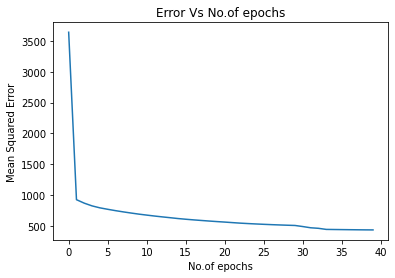

In [ ]:
plt.plot(history.history['mse'])
plt.xlabel('No.of epochs')
plt.ylabel('Mean Squared Error')
plt.title('Error Vs No.of epochs')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([[144.71251],
       [152.44933],
       [161.12564],
       ...,
       [162.85693],
       [156.3461 ],
       [151.2276 ]], dtype=float32)

In [ ]:
pd.DataFrame([[a,b] for a,b in zip(y_test, y_pred)], columns=['Y_Test','Prediction'])

,Y_Test,Prediction
0,173,[144.71251]
1,136,[152.44933]
2,188,[161.12564]
3,164,[154.96492]
4,164,[160.89723]
...,...,...
35717,171,[178.82343]
35718,104,[105.96123]
35719,137,[162.85693]
35720,169,[156.3461]
